# Task 1
- Extract the training data, run: python genData.py
- Start a jupyter notebook
- Read in the data as one dataframe (containing all data from all files)
- Learn a vanilla* logistic regression:
    - Craft some features (but let’s discuss this first once you are ready)
    - Use the returnLabel as label
    - Split data randomly (seed = 0) into training (70%) and test (30%)
    - Learn the classification model
- Do the same for Gradient boosted tree (gbt)
- Compare the two models on the test data and decide for one

In [41]:
import pandas as pd
import os

In [42]:
dfList = []
for i, file in enumerate(os.listdir('data/return-data')):
    df_ = pd.read_json('data/return-data/' + file, lines=True)
    df_['date'] = file[:-4]
    dfList.append(df_)
df = pd.concat(dfList).reset_index(drop=True)

## Exploring the dataset

In [43]:
df.head()

,basket,returnLabel,totalAmount,transactionId,zipCode,date
0,[0],0,60,2036784096,6885,2017-01-23
1,"[3, 3, 1, 5, 2, 4]",0,306,3510985428,5350,2017-01-23
2,"[1, 2, 3]",0,30,4697354814,6158,2017-01-23
3,"[5, 3, 4, 2, 2, 2, 0, 0]",0,352,9791079221,8775,2017-01-23
4,"[4, 3, 4, 0, 3, 1, 1, 3]",0,624,8033769448,1146,2017-01-23


In [22]:
df.groupby('returnLabel').count()

,basket,totalAmount,transactionId,zipCode,date
returnLabel,,,,,
0,30082,30082,30082,30082,30082
1,918,918,918,918,918


In [23]:
df.groupby('returnLabel').mean().loc[:,['totalAmount']]

,totalAmount
returnLabel,
0,237.359850
1,320.222222


In [24]:
df['noBaskets'] = df.basket.apply(lambda x: len(x))
df.head(2)

,basket,returnLabel,totalAmount,transactionId,zipCode,date,noBaskets
0,[0],0,60,2036784096,6885,2017-01-23,1
1,"[3, 3, 1, 5, 2, 4]",0,306,3510985428,5350,2017-01-23,6


In [25]:
df['uniqueBaskets'] = df.basket.apply(lambda x: set(x))
df.head(2)

,basket,returnLabel,totalAmount,transactionId,zipCode,date,noBaskets,uniqueBaskets
0,[0],0,60,2036784096,6885,2017-01-23,1,{0}
1,"[3, 3, 1, 5, 2, 4]",0,306,3510985428,5350,2017-01-23,6,"{1, 2, 3, 4, 5}"


In [26]:
basket_max = df['uniqueBaskets'].apply(lambda x: max(x)).max()
for i in range(basket_max + 1):
    df['cat' + str(i)] = df.basket.apply(lambda x: x.count(i))
df.head(2)

,basket,returnLabel,totalAmount,transactionId,zipCode,date,noBaskets,uniqueBaskets,cat0,cat1,cat2,cat3,cat4,cat5
0,[0],0,60,2036784096,6885,2017-01-23,1,{0},1,0,0,0,0,0
1,"[3, 3, 1, 5, 2, 4]",0,306,3510985428,5350,2017-01-23,6,"{1, 2, 3, 4, 5}",0,1,1,2,1,1


In [27]:
df['noDifferentBaskets'] = df.uniqueBaskets.apply(lambda x: len(x))
df.head(2)

,basket,returnLabel,totalAmount,transactionId,zipCode,date,noBaskets,uniqueBaskets,cat0,cat1,cat2,cat3,cat4,cat5,noDifferentBaskets
0,[0],0,60,2036784096,6885,2017-01-23,1,{0},1,0,0,0,0,0,1
1,"[3, 3, 1, 5, 2, 4]",0,306,3510985428,5350,2017-01-23,6,"{1, 2, 3, 4, 5}",0,1,1,2,1,1,5


In [28]:
df["zipCode"] = df["zipCode"].astype('category',categories=list(range(1000,10000)))
dummies = pd.get_dummies(df.zipCode, prefix="zip")
df = pd.concat([df, dummies], axis=1)
df.head(2)

/Users/falkvandermeirsch/Documents/DSR/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  """Entry point for launching an IPython kernel.


,basket,returnLabel,totalAmount,transactionId,zipCode,date,noBaskets,uniqueBaskets,cat0,cat1,...,zip_9990,zip_9991,zip_9992,zip_9993,zip_9994,zip_9995,zip_9996,zip_9997,zip_9998,zip_9999
0,[0],0,60,2036784096,6885,2017-01-23,1,{0},1,0,...,0,0,0,0,0,0,0,0,0,0
1,"[3, 3, 1, 5, 2, 4]",0,306,3510985428,5350,2017-01-23,6,"{1, 2, 3, 4, 5}",0,1,...,0,0,0,0,0,0,0,0,0,0


In [29]:
df = df.drop(['basket', 'uniqueBaskets', 'date', 'zipCode', 'transactionId'], 1)
df.head()

,returnLabel,totalAmount,noBaskets,cat0,cat1,cat2,cat3,cat4,cat5,noDifferentBaskets,...,zip_9990,zip_9991,zip_9992,zip_9993,zip_9994,zip_9995,zip_9996,zip_9997,zip_9998,zip_9999
0,0,60,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,306,6,0,1,1,2,1,1,5,...,0,0,0,0,0,0,0,0,0,0
2,0,30,3,0,1,1,1,0,0,3,...,0,0,0,0,0,0,0,0,0,0
3,0,352,8,2,0,3,1,1,1,5,...,0,0,0,0,0,0,0,0,0,0
4,0,624,8,1,2,0,3,2,0,4,...,0,0,0,0,0,0,0,0,0,0


In [39]:
baskets = []
for i in range(6):
    cat = 'cat' + str(i)
    baskets.append(df[cat].mean())
baskets

[0.7656774193548387,
 0.7731612903225806,
 0.7682903225806451,
 0.7976774193548387,
 0.8105806451612904,
 0.7635161290322581]

In [47]:
df.groupby('zipCode').count().sort_values('date', ascending=False).head()

,basket,returnLabel,totalAmount,transactionId,date
zipCode,,,,,
2246,13,13,13,13,13
2396,12,12,12,12,12
6118,12,12,12,12,12
1412,12,12,12,12,12
2030,11,11,11,11,11


In [63]:
import json
with open('imputations.json', 'r') as f:
    imp = json.load(f)
print(imp['bla'])

None


In [60]:
json.load({"transactionId": 2983168639, "basket": [1, 4], "zipCode": 7312, "totalAmount": null})

NameError: name 'null' is not defined

## Training the dataset

In [31]:
y = df.returnLabel
X = df.drop(['returnLabel', 'noBaskets', 'noDifferentBaskets'], 1)

In [32]:
X.shape

(31000, 9007)

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

In [34]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21700, 9007)
(9300, 9007)
(21700,)
(9300,)


In [35]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=0)

In [36]:
logreg.fit(X_train, y_train)

/Users/falkvandermeirsch/Documents/DSR/env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [37]:
from joblib import dump, load
dump(logreg, 'logreg.joblib') 

['logreg.joblib']

In [26]:
y_pred_logreg = logreg.predict(X_test)
y_pred_logreg

array([0, 0, 0, ..., 0, 0, 0])

In [28]:
df = pd.DataFrame([(1, 2, 3)], columns=['basket', 'zipCode', 'totalAmount'])
df

,basket,zipCode,totalAmount
0,1,2,3


In [53]:
import numpy as np
unique, counts = np.unique(y_pred_logreg, return_counts=True)
print(unique)
print(counts)

[0 1]
[9262   38]


In [16]:
logreg.score(X_test, y_test)

0.9710752688172043

This is a bad evaluation metric in this case because we have a very imabalanced dataset

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
gbt = GradientBoostingClassifier(random_state=0, n_estimators=100)

In [29]:
gbt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [30]:
y_pred_gbt = gbt.predict(X_test)

In [32]:
unique, counts = np.unique(y_pred_gbt, return_counts=True)
print(unique)
print(counts)

[0 1]
[9198  102]


In [33]:
gbt.score(X_test, y_test)

0.9672043010752688

In [37]:
from sklearn.metrics import f1_score
print(f1_score(y_test, y_pred_logreg, average='macro'))
print(f1_score(y_test, y_pred_gbt, average='macro'))

0.6575144565463734
0.5975700123899914


# Task 2
- Implement the generation of a roc curve.
- Implement the calculation of auc.
- Use this function to generate the roc curves for the predictions on test data from Task 1.
- Compare them to the roc curves produced by the sklearn library.

In [84]:
test_scores_logreg = logreg.predict_proba(X_test)
test_scores_gbt = gbt.predict_proba(X_test)

In [82]:
probs_logreg = pd.DataFrame(index=range(len(y_test)))
probs_logreg['probability'] = test_scores_logreg[:,1]
probs_logreg['label'] = y_test.reset_index(drop=True)

In [85]:
probs_gbt = pd.DataFrame(index=range(len(y_test)))
probs_gbt['probability'] = test_scores_gbt[:,1]
probs_gbt['label'] = y_test.reset_index(drop=True)

In [86]:
probs_logreg_sorted = probs_logreg.sort_values('probability', ascending=False)
probs_gbt_sorted = probs_gbt.sort_values('probability', ascending=False)

In [87]:
probs_logreg_sorted.head()

,probability,label
158,0.997976,1
745,0.996537,1
8533,0.995347,1
7588,0.991170,1
7669,0.990297,1


In [88]:
probs_gbt_sorted.head()

,probability,label
4489,0.991138,0
7588,0.986314,1
125,0.979142,0
4751,0.975255,0
4299,0.973800,0


In [89]:
def get_roc_lists(probs_sorted):
    fpr_list = []
    tpr_list = []
    precision_list = []
    for i in range(len(probs_sorted) + 1):
        tp = probs_sorted.iloc[:i,1].sum()
        fp = probs_sorted.iloc[:i,1].count() - probs_sorted.iloc[:i,1].sum()
        fn = probs_sorted.iloc[i:,1].sum()
        tn = probs_sorted.iloc[i:,1].count() - probs_sorted.iloc[i:,1].sum()
        
        #ap = probs_sorted.iloc[:,1].sum()
        #an = probs_sorted.iloc[:,1].count() - probs_sorted.iloc[:,1].sum()

        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        
        precision = tp / (tp + fp)
        #recall = tpr
        
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        precision_list.append(precision)
    return fpr_list, tpr_list, precision_list

In [77]:
fpr_list_logreg, tpr_list_logreg, precision_list_logreg = get_roc_lists(probs_logreg_sorted)
fpr_list_gbt, tpr_list_gbt, precision_list_gbt = get_roc_lists(probs_gbt_sorted)

/Users/falkvandermeirsch/Documents/DSR/env/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


No handles with labels found to put in legend.


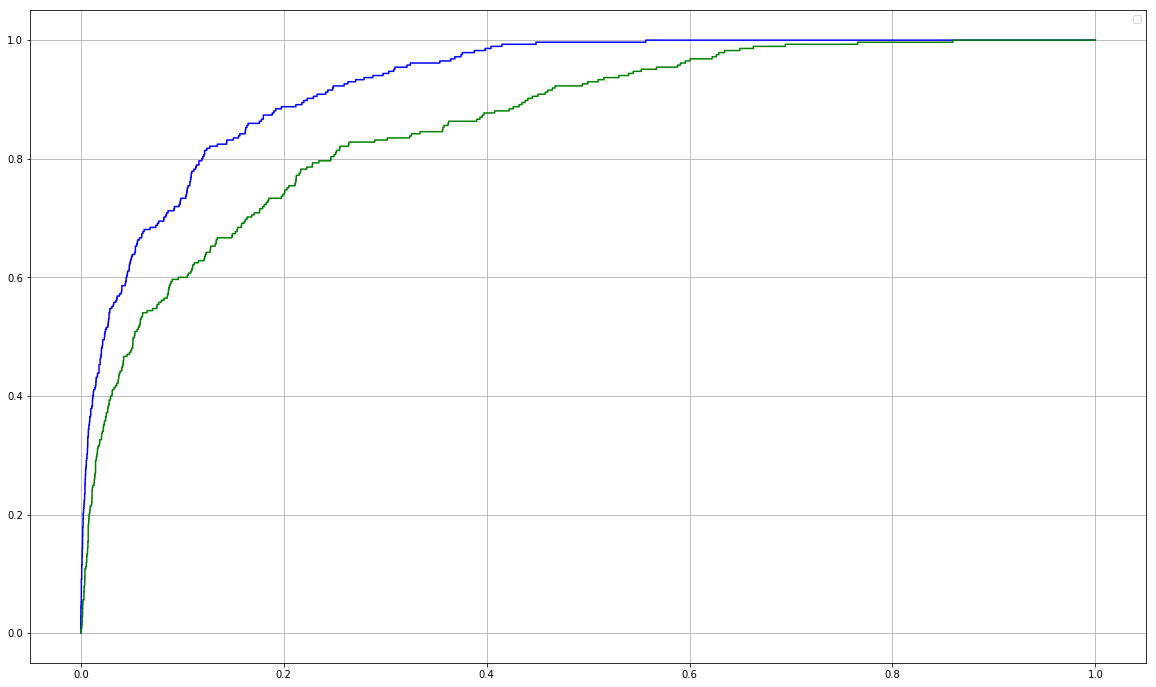

In [80]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,12))
plt.plot(fpr_list_logreg, tpr_list_logreg, c='blue')
plt.plot(fpr_list_gbt, tpr_list_gbt, c='green')
plt.legend()
plt.grid()
plt.show()

No handles with labels found to put in legend.


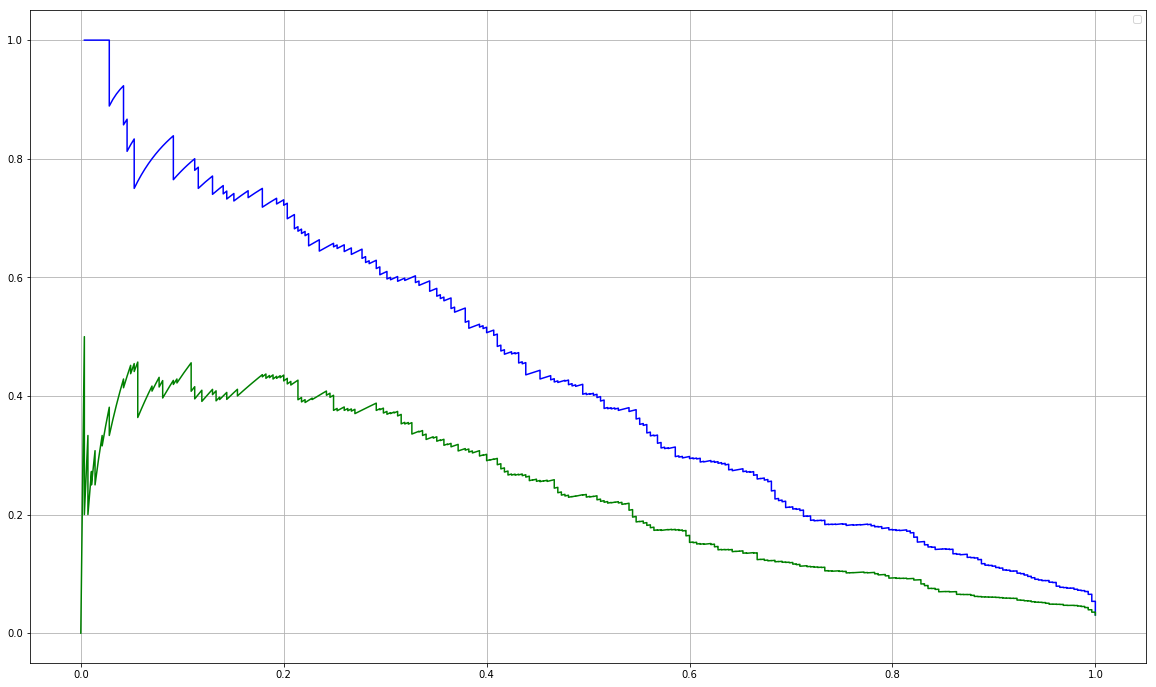

In [79]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,12))
plt.plot(tpr_list_logreg, precision_list_logreg, c='blue')
plt.plot(tpr_list_gbt, precision_list_gbt, c='green')
plt.legend()
plt.grid()
plt.show()

In [90]:
def auc(fpr_list, tpr_list):
    auc = 0
    for i in range(1, len(fpr_list)):
        auc += (fpr_list[i] - fpr_list[i-1]) * tpr_list[i]
    return auc

In [91]:
auc(fpr_list_logreg, tpr_list_logreg)

0.928578684648371

In [92]:
auc(fpr_list_gbt, tpr_list_gbt)

0.8594953829387083

# Task 3

## Undersampling

In [ ]:
df['returnLabel'].sum()

In [ ]:
df.shape

In [ ]:
df_u = pd.concat([df.loc[df.returnLabel == 0,:].sample(n=918), df.loc[df.returnLabel == 1,:]])

In [ ]:
df_u.shape

In [ ]:
y_u = df_u.returnLabel
X_u = df_u.drop(['returnLabel'], 1)
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_u, y_u, random_state=0)

In [ ]:
X_test_u.shape

In [ ]:
log_clf.fit(X_train_u, y_train_u)

In [ ]:
gbt_clf.fit(X_train_u, y_train_u)

In [ ]:
test_preds_probs_log_u = log_clf.predict_proba(X_test_u)
test_preds_probs_gbt_u = gbt_clf.predict_proba(X_test_u)

In [ ]:
table_logreg_u = np.concatenate([np.expand_dims(test_preds_probs_log_u[:,1], 1), np.expand_dims(y_test_u, 1)], axis=1)
table_gbt_u = np.concatenate([np.expand_dims(test_preds_probs_gbt_u[:,1], 1), np.expand_dims(y_test_u, 1)], axis=1)


In [ ]:
probs_logreg_u = pd.DataFrame(table_logreg_u, columns=['probability', 'label'])
probs_gbt_u = pd.DataFrame(table_gbt_u, columns=['probability', 'label'])

In [ ]:
probs_logreg_u_sorted = probs_logreg_u.sort_values('probability', ascending=False)
probs_gbt_u_sorted = probs_gbt_u.sort_values('probability', ascending=False)

In [ ]:
fpr_list_logreg_u, tpr_list_logreg_u, precision_list_logreg_u = get_roc_lists(probs_logreg_u_sorted)
fpr_list_gbt_u, tpr_list_gbt_u, precision_list_gbt_u = get_roc_lists(probs_gbt_u_sorted)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,12))
plt.plot(fpr_list_logreg_u, tpr_list_logreg_u, c='blue')
plt.plot(fpr_list_gbt_u, tpr_list_gbt_u, c='green')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(auc(fpr_list_logreg_u, tpr_list_logreg_u))
print(auc(fpr_list_gbt_u, tpr_list_gbt_u))

## Oversampling

In [ ]:
len(df) / len(df[df.returnLabel == 1])

In [ ]:
li = [df]
for i in range(33):
    li.append(df[df.returnLabel == 1])
df_o = pd.concat(li)

In [ ]:
df_o

In [ ]:
y_o = df_o.returnLabel
X_o = df_o.drop(['returnLabel', 'basket', 'uniqueBaskets', 'date', 'zipCode', 'transactionId'], 1)
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_o, y_o, random_state=0)

In [ ]:
log_clf.fit(X_train_o, y_train_o)
gbt_clf.fit(X_train_o, y_train_o)

In [ ]:
test_preds_probs_log_o = log_clf.predict_proba(X_test_o)
test_preds_probs_gbt_o = gbt_clf.predict_proba(X_test_o)

In [ ]:
table_logreg_o = np.concatenate([np.expand_dims(test_preds_probs_log_o[:,1], 1), np.expand_dims(y_test_o, 1)], axis=1)
table_gbt_o = np.concatenate([np.expand_dims(test_preds_probs_gbt_o[:,1], 1), np.expand_dims(y_test_o, 1)], axis=1)

In [ ]:
probs_logreg_o = pd.DataFrame(table_logreg_o, columns=['probability', 'label'])
probs_gbt_o = pd.DataFrame(table_gbt_o, columns=['probability', 'label'])

In [ ]:
fpr_list_logreg_o, tpr_list_logreg_o, precision_list_logreg_o = get_roc_lists(probs_logreg_o_sorted)
fpr_list_gbt_o, tpr_list_gbt_o, precision_list_gbt_o = get_roc_lists(probs_gbt_o_sorted)

In [ ]:
plt.figure(figsize=(20,12))
plt.plot(fpr_list_logreg_o, tpr_list_logreg_o, c='blue')
plt.plot(fpr_list_gbt_o, tpr_list_gbt_o, c='green')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(auc(fpr_list_logreg_o, tpr_list_logreg_o))
print(auc(fpr_list_gbt_o, tpr_list_gbt_o))

Task 4
- Check the calibration error of the models from task 1:
    - Form buckets of 100 consecutive predictions (starting from lowest probability).
    - Plot the error (x-axis: predicted probability, y-axis: real prob.)
    - Calculate the mean error over all buckets.
- Learn a calibration algorithm on the training data of task 1 and use it on the prediction of the test data.
- Compare the outcome to the uncalibrated case.

In [76]:
y_prob = logreg.predict_proba(X_test)[:,1]

In [112]:
df1 = pd.DataFrame(y_test.reset_index(drop=True))
df1.rename(columns={'returnLabel': 'y_test'})
df1['y_pred'] = y_prob

In [111]:
df1_s = df1.sort_values('y_pred')

In [101]:
buckets = []
for i in range(0, len(df1_s), 100):
    p_real = df1_s.y_test[i:i+100].sum() / 100
    p_pred = df1_s.y_pred[i:i+100].sum() / 100
    err = p_real - p_pred
    buckets.append((p_pred, p_real, err))

In [107]:
buckets_df = pd.DataFrame(buckets, columns=['p_pred', 'p_real', 'err'])

In [109]:
mean_err = buckets_df.err.mean()
mean_err

0.0005152298280370165

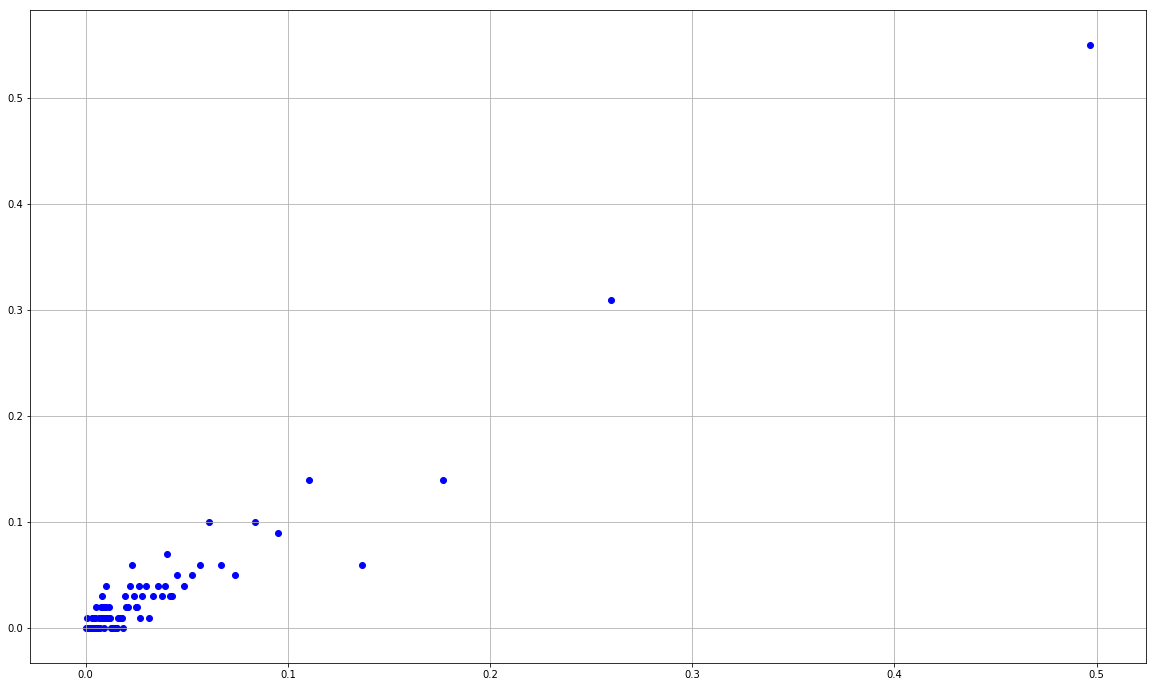

In [113]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,12))
plt.scatter(buckets_df.p_pred, buckets_df.p_real, c='blue')
plt.grid()
plt.show()

In [114]:
y_prob_t = logreg.predict_proba(X_train)[:,1]

In [120]:
df2 = pd.DataFrame(y_train.reset_index(drop=True))
df2 = df2.rename(columns={'returnLabel': 'y_train'})
df2['y_pred'] = y_prob_t

In [121]:
df2_s = df2.sort_values('y_pred')

In [122]:
buckets2 = []
for i in range(0, len(df2_s), 100):
    p_real = df2_s.y_train[i:i+100].sum() / 100
    p_pred = df2_s.y_pred[i:i+100].sum() / 100
    err = p_real - p_pred
    buckets2.append((p_pred, p_real, err))

In [123]:
buckets2_df = pd.DataFrame(buckets, columns=['p_pred', 'p_real', 'err'])

In [124]:
calibrated_pred = 

,p_pred,p_real,err
0,0.000284,0.00,-0.000284
1,0.000565,0.00,-0.000565
2,0.000786,0.01,0.009214
3,0.001028,0.00,-0.001028
4,0.001228,0.00,-0.001228
5,0.001421,0.00,-0.001421
6,0.001637,0.00,-0.001637
7,0.001843,0.00,-0.001843
8,0.002065,0.00,-0.002065
9,0.002258,0.00,-0.002258
